In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.datasets import CIFAR10
from torchvision import transforms
from sklearn.utils import resample
from sklearn.metrics import accuracy_score


In [2]:
# 2. Caricamento del dataset CIFAR-10 e trasformazione in tensori
transform = transforms.Compose([transforms.ToTensor()])
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s] 


In [3]:
# 3. Estrazione immagini in vettori e label
X_train = np.array([np.array(img).flatten() for img, _ in train_set])
y_train = np.array([label for _, label in train_set])
X_test = np.array([np.array(img).flatten() for img, _ in test_set])
y_test = np.array([label for _, label in test_set])


In [4]:
# 4. Sottocampionamento bilanciato: 200 immagini per classe
def undersample_balanced(X, y):
    X_res, y_res = [], []
    for cls in np.unique(y):
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        X_down, y_down = resample(X_cls, y_cls, n_samples=200, random_state=42)
        X_res.append(X_down)
        y_res.append(y_down)
    return np.vstack(X_res), np.hstack(y_res)

X_train_resampled, y_train_resampled = undersample_balanced(X_train, y_train)

In [5]:

# 5. Standardizzazione e PCA (dim ridotta a 30 componenti)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [6]:
# 6. Funzione generica per model training con GridSearchCV
def train_model(model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

In [7]:
# 7. Definizione dei modelli e dei relativi iperparametri
model_configs = [
    ("Logistic Regression", LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    ("k-NN", KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    ("SVM (Linear)", SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear']}),
    ("Decision Tree", DecisionTreeClassifier(), {'max_depth': [10, 20, 30, None]})
]

trained_models = {}
accuracies = {}

Logistic Regression - Best Params: {'C': 0.1}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.41      0.40      1000
           1       0.38      0.37      0.37      1000
           2       0.23      0.19      0.21      1000
           3       0.23      0.21      0.22      1000
           4       0.33      0.27      0.29      1000
           5       0.30      0.29      0.30      1000
           6       0.34      0.41      0.37      1000
           7       0.36      0.35      0.35      1000
           8       0.42      0.48      0.45      1000
           9       0.38      0.44      0.40      1000

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



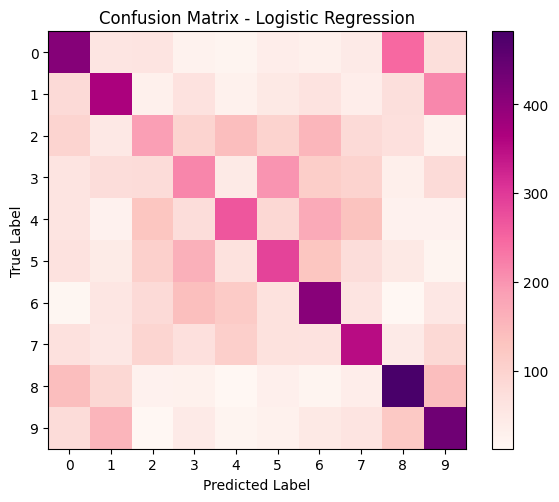

k-NN - Best Params: {'n_neighbors': 5}

k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.53      0.37      1000
           1       0.36      0.22      0.27      1000
           2       0.18      0.27      0.22      1000
           3       0.23      0.18      0.20      1000
           4       0.23      0.35      0.28      1000
           5       0.36      0.17      0.23      1000
           6       0.27      0.37      0.32      1000
           7       0.43      0.16      0.23      1000
           8       0.41      0.47      0.44      1000
           9       0.48      0.18      0.26      1000

    accuracy                           0.29     10000
   macro avg       0.32      0.29      0.28     10000
weighted avg       0.32      0.29      0.28     10000



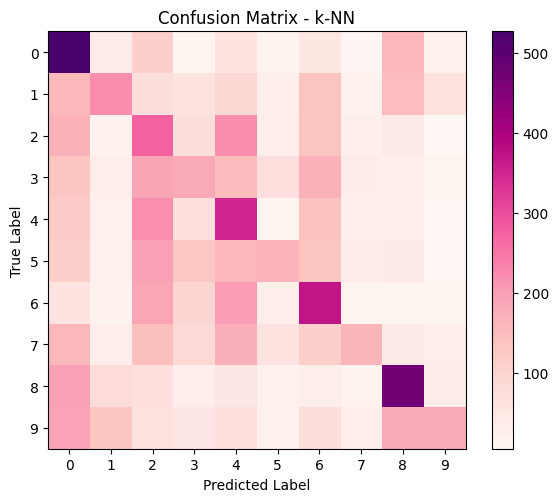

In [ ]:
# 8–9. Training + valutazione dei modelli
for name, model, params in model_configs:
    try:
        best_model, best_params = train_model(model, params, X_train_pca, y_train_resampled)
        print(f"{name} - Best Params: {best_params}")

        y_pred = best_model.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)

        trained_models[name] = best_model
        accuracies[name] = accuracy

        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, cmap="RdPu")
        plt.title(f"Confusion Matrix - {name}")
        plt.colorbar()
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(np.arange(10))
        plt.yticks(np.arange(10))
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Errore durante l'esecuzione di {name}: {e}")

In [ ]:
# 10. Selezione automatica del miglior modello
best_model_name = max(accuracies, key=accuracies.get)
print(f"\n Best Model based on accuracy: {best_model_name} ({accuracies[best_model_name]:.4f})")